# Preprocessing

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [2]:
team_data = pd.read_csv("../data/MRegularSeasonDetailedResults.csv")
team_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [3]:
#subest to data from the past season
team_data = team_data[team_data['Season'] == 2022].copy().reset_index(drop = True)

In [4]:
#calculating possesions for win
# to calculate defensive efficiency we need to estimate possessions i will use the Dean Oliver method
# poss = FGA + ((.4 * FTA) - ((1.07 * ORB_Pct) * (FGA - FGM))) + TOV
#where ORB_Pct = oRB / (ORB + OPP_DRB)
for x in team_data:
    WPos = team_data.WFGA + ((.4 + team_data.WFGM) - 
                                      ((1.07 * (team_data.WOR/ (team_data.WOR + team_data.LOR)) *
                                        (team_data.WFGA - team_data.WFGM)))) + team_data.WTO
team_data['WPos'] = WPos.round(2)

In [5]:
#calculating possesions for loss
for x in team_data:
    LPos = team_data.LFGA + ((.4 + team_data.LFGM) - 
                                      ((1.07 * (team_data.LOR/ (team_data.LOR + team_data.WOR)) *
                                        (team_data.LFGA - team_data.LFGM)))) + team_data.LTO
team_data['LPos'] = LPos.round(2)

In [6]:
#calculating offensive efficiency for win
for x in team_data:
    WOE = (team_data.WScore / team_data.WPos) * 100
team_data['WOE'] = WOE.round(2)
#offensive effeiciency is other teams defensive efficency
team_data['LDE'] = WOE.round(2)

In [7]:
#calculating offensive efficency for 
for x in team_data:
    LOE = (team_data.LScore / team_data.LPos) * 100 
team_data['LOE'] = LOE.round(2)
team_data['WDE'] = LOE.round(2)

In [8]:
#true shooting percentage is PTS / (2*TSA) where TSA is FGA + .44 + FTA
for x in team_data: 
    WTSA = team_data.WScore / (2 * (team_data.WFGA + .44 * team_data.WFTA))
team_data['WTSA'] = WTSA.round(2)

In [9]:
for x in team_data: 
    LTSA = team_data.LScore / (2 * (team_data.LFGA + .44 * team_data.LFTA))
team_data['LTSA'] = LTSA.round(2)

In [10]:
#points per possession
for x in team_data: 
    WPPP = team_data.WScore / team_data.WPos
team_data['WPPP'] = WPPP.round(2)

In [11]:
for x in team_data: 
    LPPP = team_data.LScore / team_data.LPos
team_data['LPPP'] = LPPP.round(2)

In [12]:
team_data['Wwins'] = team_data.groupby('WTeamID').cumcount()

In [13]:
team_data['L_loss'] = team_data.groupby('LTeamID').cumcount()

In [14]:
#winning team losses 
WTeam_losses = []
for index,row in team_data.iterrows():
    winning_id = row['WTeamID']
    losses = (team_data[0:index].LTeamID.values==winning_id).sum()
    WTeam_losses.append(losses)
team_data['W_loss'] = WTeam_losses

In [15]:
#losing team wins
LTeam_wins = []
for index,row in team_data.iterrows():
    losing_id = row['LTeamID']
    wins = (team_data[0:index].WTeamID.values==losing_id).sum()
    LTeam_wins.append(wins)
team_data['L_wins'] = LTeam_wins

In [16]:
#total games
team_data['W_total_games'] = (team_data.Wwins + team_data.W_loss)
team_data['L_total_games'] = (team_data.L_loss + team_data.L_wins)

## Descriptive Stats

In [17]:
team_data[['WPPP', 'LPPP', 'WDE', 'LDE', 'WTSA', 'LTSA', 'WDR','LDR', 'WStl', 'LStl']].describe().round(2)

,WPPP,LPPP,WDE,LDE,WTSA,LTSA,WDR,LDR,WStl,LStl
count,5344.00,5344.00,5344.00,5344.00,5345.00,5345.00,5345.00,5345.00,5345.00,5345.00
mean,0.96,0.85,85.36,95.88,0.58,0.50,25.36,21.46,6.82,6.03
std,0.10,0.11,11.17,10.03,0.07,0.07,4.73,4.38,3.01,2.69
min,0.63,0.39,39.24,62.59,0.37,0.24,11.00,6.00,0.00,0.00
25%,0.89,0.78,77.95,89.07,0.53,0.45,22.00,18.00,5.00,4.00
50%,0.95,0.85,85.06,95.38,0.58,0.50,25.00,21.00,6.00,6.00
75%,1.02,0.92,92.41,102.10,0.63,0.54,28.00,24.00,9.00,8.00
max,1.43,1.31,131.24,143.05,0.84,0.77,44.00,44.00,22.00,19.00


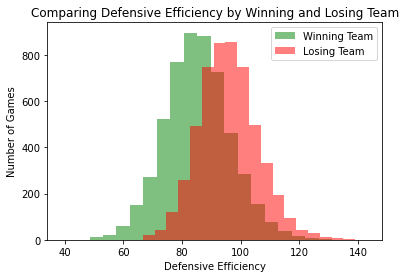

In [18]:
plt.hist(team_data.WDE, 20, color = "Green", alpha = .5)
plt.hist(team_data.LDE, 20, color = "Red", alpha = .5)
plt.xlabel("Defensive Efficiency")
plt.ylabel("Number of Games")
plt.title("Comparing Defensive Efficiency by Winning and Losing Team")
plt.legend(['Winning Team', 'Losing Team'])
#plt.savefig("Defensive_Efficiency")

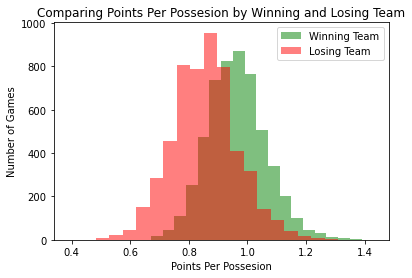

In [19]:
plt.hist(team_data.WPPP, 20, color = "Green", alpha = .5)
plt.hist(team_data.LPPP, 20, color = "Red", alpha = .5)
plt.xlabel("Points Per Possesion")
plt.ylabel("Number of Games")
plt.title("Comparing Points Per Possesion by Winning and Losing Team")
plt.legend(['Winning Team', 'Losing Team'])
#plt.savefig("PointsPerPossesion", format = 'png')

## Data Manipulation

In [20]:
swapped_df = team_data.copy()

In [21]:
#replacing winning and losing team with t1 and t2
swapped_df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(swapped_df.columns)]

In [22]:
swapped_df.rename(columns= {'T1_T2_oc': 'WLoc'}, 
                  inplace= True)

In [23]:
swapped_df.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,WLoc,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_Pos,T2_Pos,T1_OE,T2_DE,T2_OE,T1_DE,T1_TSA,T2_TSA,T1_PPP,T2_PPP,T1_wins,T2__loss,T1__loss,T2__wins,T1__total_games,T2__total_games
0,2022,8,1104,93,1256,64,H,0,32,64,13,33,16,23,14,34,19,13,9,2,19,26,67,6,26,6,19,14,20,11,10,3,1,18,92.28,81.46,100.78,100.78,78.57,78.57,0.63,0.42,1.01,0.79,0,0,0,0,0,0
1,2022,8,1105,82,1398,73,H,0,31,71,7,17,13,21,14,23,16,8,6,1,10,30,72,11,27,2,5,14,27,12,14,5,2,16,89.00,93.93,92.13,92.13,77.72,77.72,0.51,0.49,0.92,0.78,0,0,0,0,0,0
2,2022,8,1110,77,1265,73,H,1,27,59,5,19,18,26,7,29,17,14,5,4,12,31,68,4,19,7,12,10,26,5,15,6,3,20,86.30,91.11,89.22,89.22,80.12,80.12,0.55,0.50,0.89,0.80,0,0,0,0,0,0
3,2022,8,1112,81,1319,52,H,0,28,69,8,25,17,24,14,28,25,6,11,9,16,19,53,5,16,9,17,11,28,11,20,3,1,22,78.83,76.39,102.75,102.75,68.07,68.07,0.51,0.43,1.03,0.68,0,0,0,0,0,0
4,2022,8,1113,76,1339,60,H,0,31,66,7,26,7,9,13,29,15,19,10,3,16,22,54,6,24,10,11,2,22,10,21,9,1,14,83.94,92.83,90.54,90.54,64.63,64.63,0.54,0.51,0.91,0.65,0,0,0,0,0,0


### Past Game Average

Taking the average of the teams past game in place of the current game stats

In [24]:
test = swapped_df.copy()
test

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,WLoc,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_Pos,T2_Pos,T1_OE,T2_DE,T2_OE,T1_DE,T1_TSA,T2_TSA,T1_PPP,T2_PPP,T1_wins,T2__loss,T1__loss,T2__wins,T1__total_games,T2__total_games
0,2022,8,1104,93,1256,64,H,0,32,64,13,33,16,23,14,34,19,13,9,2,19,26,67,6,26,6,19,14,20,11,10,3,1,18,92.28,81.46,100.78,100.78,78.57,78.57,0.63,0.42,1.01,0.79,0,0,0,0,0,0
1,2022,8,1105,82,1398,73,H,0,31,71,7,17,13,21,14,23,16,8,6,1,10,30,72,11,27,2,5,14,27,12,14,5,2,16,89.00,93.93,92.13,92.13,77.72,77.72,0.51,0.49,0.92,0.78,0,0,0,0,0,0
2,2022,8,1110,77,1265,73,H,1,27,59,5,19,18,26,7,29,17,14,5,4,12,31,68,4,19,7,12,10,26,5,15,6,3,20,86.30,91.11,89.22,89.22,80.12,80.12,0.55,0.50,0.89,0.80,0,0,0,0,0,0
3,2022,8,1112,81,1319,52,H,0,28,69,8,25,17,24,14,28,25,6,11,9,16,19,53,5,16,9,17,11,28,11,20,3,1,22,78.83,76.39,102.75,102.75,68.07,68.07,0.51,0.43,1.03,0.68,0,0,0,0,0,0
4,2022,8,1113,76,1339,60,H,0,31,66,7,26,7,9,13,29,15,19,10,3,16,22,54,6,24,10,11,2,22,10,21,9,1,14,83.94,92.83,90.54,90.54,64.63,64.63,0.54,0.51,0.91,0.65,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5340,2022,132,1222,71,1272,53,N,0,25,58,8,24,13,19,13,21,20,9,10,3,16,22,51,1,10,8,14,9,25,15,15,5,4,19,71.54,75.71,99.25,99.25,70.00,70.00,0.53,0.46,0.99,0.70,28,9,5,21,33,30
5341,2022,132,1234,75,1345,66,N,0,26,61,8,28,15,23,10,20,15,6,13,3,17,25,59,5,20,11,17,17,31,13,17,4,2,22,79.53,78.49,94.30,94.30,84.09,84.09,0.53,0.50,0.94,0.84,25,6,9,27,34,33
5342,2022,132,1350,64,1172,62,N,0,22,51,5,16,15,18,4,29,8,11,5,0,17,19,51,9,27,15,17,4,26,12,9,4,2,16,68.88,62.28,92.92,92.92,99.55,99.55,0.54,0.53,0.93,1.00,22,5,12,26,34,31
5343,2022,132,1397,65,1401,50,N,0,22,56,12,28,9,14,12,29,19,13,8,4,14,16,51,4,19,14,18,10,24,6,12,6,0,14,71.56,62.38,90.83,90.83,80.15,80.15,0.52,0.42,0.91,0.80,25,11,7,22,32,33


In [25]:
#add game id as reference
test['gameID'] = range(test.shape[0])

In [26]:
#make data long so each row is one teams data for one game 
df_list = []
for i in range(1,3):
        tmp = test[["gameID", f"T{i}_TeamID", f"T{i}_Score", f"T{i}_FGM", f"T{i}_FGA", f"T{i}_FGM3", f"T{i}_FGA3", f"T{i}_FTM",
              f"T{i}_FTA", f"T{i}_OR", f"T{i}_DR", f"T{i}_Ast", f"T{i}_TO", f"T{i}_Stl", f"T{i}_Blk", f"T{i}_PF",
             f"T{i}_Pos", f"T{i}_OE", f"T{i}_DE", f"T{i}_TSA", f"T{i}_PPP", f"T{i}__total_games"]].copy()
        tmp.columns = ["gameID", 'team_id', "Score", 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl',
                  'Blk', 'PF', 'Pos', 'OE', 'DE', 'TSA', 'PPP', 'total_games']
        df_list.append(tmp)
        df_long = pd.concat(df_list)

In [27]:
df_long = df_long.sort_values("gameID").reset_index(drop= True)

In [28]:
df_long.head()

,gameID,team_id,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Pos,OE,DE,TSA,PPP,total_games
0,0,1104,93,32,64,13,33,16,23,14,34,19,13,9,2,19,92.28,100.78,78.57,0.63,1.01,0
1,0,1256,64,26,67,6,26,6,19,14,20,11,10,3,1,18,81.46,78.57,100.78,0.42,0.79,0
2,1,1398,73,30,72,11,27,2,5,14,27,12,14,5,2,16,93.93,77.72,92.13,0.49,0.78,0
3,1,1105,82,31,71,7,17,13,21,14,23,16,8,6,1,10,89.00,92.13,77.72,0.51,0.92,0
4,2,1110,77,27,59,5,19,18,26,7,29,17,14,5,4,12,86.30,89.22,80.12,0.55,0.89,0


In [29]:
#get average data for each variable and shift so current cell contains average for previous games
def average(stat):
    df_long[f'avg_{stat}']= (df_long.groupby('team_id')[stat].
                              apply(lambda x : x.shift().cumsum()).values/df_long.total_games).round(2)

In [30]:
average('Score')
average('FGM')
average('FGA')
average('FGM3')
average('FGA3')
average('FTA')
average('FTM')
average('OR')
average('DR')
average('Ast')
average('TO')
average('Stl')
average('Blk')
average('PF')
average('Pos')
average('OE')
average('DE')
average('TSA')
average('PPP')

In [31]:
#getting columns to use
cols =  df_long.columns[df_long.columns.str.startswith('avg')].tolist()
#adding other necessary columns
cols = cols + ['gameID', 'team_id', 'Score']
print(cols)
average_long = df_long[['avg_Score', 'avg_FGM', 'avg_FGA', 'avg_FGM3', 'avg_FGA3', 'avg_FTA', 'avg_FTM', 'avg_OR', 'avg_DR', 
         'avg_Ast', 'avg_TO', 'avg_Stl', 'avg_Blk', 'avg_PF', 'avg_Pos', 'avg_OE', 'avg_DE', 'avg_TSA', 'avg_PPP',
         'gameID', 'team_id', 'Score', 'total_games']]

['avg_Score', 'avg_FGM', 'avg_FGA', 'avg_FGM3', 'avg_FGA3', 'avg_FTA', 'avg_FTM', 'avg_OR', 'avg_DR', 'avg_Ast', 'avg_TO', 'avg_Stl', 'avg_Blk', 'avg_PF', 'avg_Pos', 'avg_OE', 'avg_DE', 'avg_TSA', 'avg_PPP', 'gameID', 'team_id', 'Score']


In [32]:
even = []
odd = []
#create two lists each with one team from each game- since they are sorted by game id I am using the index 
for i in range(0,10690):
    if i == 0 or i % 2:
        even.append(average_long.iloc[i])
    else:
        odd.append(average_long.iloc[i])
even = pd.DataFrame(even)
even2 = even.drop(['gameID', 'team_id'], axis = 1)
even2.columns = [f'T1_{col}' for col in list(even2.columns)]
even2['gameID']= even['gameID'] 
even2['team_id'] = even['team_id']

In [33]:
odd = pd.DataFrame(odd)
odd2 = odd.drop(['gameID', 'team_id'], axis = 1)
odd2.columns = [f'T2_{col}' for col in list(odd2.columns)]
odd2['gameID'] = odd['gameID'] 
odd2['team_id'] = odd['team_id']

In [34]:
#merge 
average_df = even2.merge(odd2, on = 'gameID', how = 'left')

In [35]:
average_df = average_df.rename(columns={'team_id_x': 'T1_TeamID', 'team_id_y': 'T2_TeamID'})

In [36]:
#get only average data and scores
average_df = average_df[['T1_avg_Score', 'T1_avg_FGM', 'T1_avg_FGA', 'T1_avg_FGM3', 'T1_avg_FGA3', 'T1_avg_FTA', 
                         'T1_avg_FTM', 'T1_avg_OR', 'T1_avg_DR', 'T1_avg_Ast', 'T1_avg_TO', 'T1_avg_Stl', 
                         'T1_avg_Blk', 'T1_avg_PF', 'T1_avg_Pos', 'T1_avg_OE', 'T1_avg_DE', 'T1_avg_TSA', 
                         'T1_avg_PPP', 'T2_avg_Score','T2_avg_FGM', 'T2_avg_FGA', 'T2_avg_FGM3', 'T2_avg_FGA3',
                         'T2_avg_FTA', 'T2_avg_FTM', 'T2_avg_OR', 'T2_avg_DR', 'T2_avg_Ast', 'T2_avg_TO', 
                         'T2_avg_Stl', 'T2_avg_Blk', 'T2_avg_PF', 'T2_avg_Pos', 'T2_avg_OE', 'T2_avg_DE', 
                         'T2_avg_TSA', 'T2_avg_PPP', 'T1_Score', 'T2_Score']]

In [37]:
#switch t1 and t2 around so t1 does not always win 
T1 = [col for col in average_df if col.startswith('T1')]
T2 = [col for col in average_df if col.startswith('T2')]

In [38]:
np.random.seed(13)
random_rows = np.random.choice(average_df.index, size=average_df.shape[0]//2, replace=False)
average_df.loc[random_rows, T1+T2] = average_df.loc[random_rows, T2+T1].values

In [39]:
average_df['outcome']= np.where(average_df.T1_Score > average_df.T2_Score,1,0)
#check tail since head will be NA 
average_df.tail(10)

,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTA,T1_avg_FTM,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_Pos,T1_avg_OE,T1_avg_DE,T1_avg_TSA,T1_avg_PPP,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTA,T2_avg_FTM,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_Pos,T2_avg_OE,T2_avg_DE,T2_avg_TSA,T2_avg_PPP,T1_Score,T2_Score,outcome
5336,79.35,29.16,62.65,7.84,20.52,17.94,13.19,10.13,24.48,13.03,11.16,9.06,4.16,16.97,82.80,95.80,84.06,0.56,0.96,73.70,26.07,57.93,8.27,23.80,18.17,13.30,7.43,24.87,13.23,11.23,6.43,1.93,14.87,79.84,92.15,89.16,0.56,0.92,82.0,73.0,1
5337,74.37,25.50,56.77,9.40,24.37,17.83,13.97,6.13,23.53,12.57,10.80,4.70,2.00,13.73,79.44,93.31,90.68,0.57,0.93,74.52,27.13,55.35,8.87,24.19,15.19,11.39,5.81,25.90,15.00,9.42,5.13,2.45,13.97,76.87,96.85,85.62,0.60,0.97,43.0,82.0,0
5338,69.69,25.97,57.16,6.81,21.62,15.00,10.94,8.12,27.47,13.28,13.44,5.44,4.47,13.44,81.09,85.67,86.72,0.55,0.86,73.22,24.78,56.28,9.34,25.72,17.31,14.31,8.72,22.94,12.16,9.44,6.25,2.31,15.41,72.54,100.80,86.12,0.58,1.01,48.0,54.0,0
5339,80.58,29.85,61.12,8.30,22.30,17.18,12.58,9.61,26.55,17.03,9.91,6.52,5.42,13.61,83.87,96.26,83.80,0.59,0.96,70.41,25.82,55.00,8.97,22.91,13.15,9.79,7.35,22.65,14.29,10.50,5.32,3.29,14.65,75.49,93.45,86.26,0.58,0.94,67.0,82.0,0
5340,72.44,26.85,60.04,8.07,24.04,14.59,10.67,7.37,24.15,12.56,11.44,5.56,2.22,17.30,81.54,89.11,93.88,0.55,0.89,72.19,25.52,58.11,6.85,21.11,19.30,14.30,7.67,25.26,12.00,12.78,6.11,3.15,17.96,79.88,90.62,90.76,0.54,0.91,61.0,67.0,0
5341,76.17,27.10,57.43,6.50,17.87,22.27,15.47,11.13,24.30,16.10,15.83,8.83,5.73,18.70,82.87,92.35,86.57,0.57,0.92,75.97,28.24,60.09,8.00,23.45,17.18,11.48,12.18,24.61,16.64,10.85,8.18,5.27,17.42,77.82,97.61,80.96,0.56,0.98,53.0,71.0,0
5342,80.21,28.33,57.18,8.85,22.42,20.88,14.70,9.58,25.67,16.73,11.18,4.64,3.55,14.12,79.05,101.49,86.51,0.60,1.02,84.03,30.03,64.56,9.32,25.18,19.47,14.65,10.59,23.82,16.12,8.85,7.24,4.41,16.12,83.53,100.51,86.26,0.57,1.00,66.0,75.0,0
5343,71.94,25.50,57.35,8.21,24.26,17.65,12.74,6.56,23.71,14.74,9.24,7.91,2.32,13.79,77.03,93.68,89.58,0.56,0.94,75.03,26.39,54.94,8.65,22.39,18.06,13.61,6.42,25.00,14.45,9.42,4.65,2.61,14.81,75.79,99.34,91.22,0.60,0.99,64.0,62.0,1
5344,72.61,25.76,58.09,6.82,20.15,20.55,14.27,9.73,21.70,13.67,13.00,9.97,3.48,18.27,79.62,91.24,86.56,0.54,0.91,73.44,26.00,60.28,8.66,24.34,17.91,12.78,10.44,23.81,16.03,11.88,9.31,4.38,17.06,77.43,95.17,82.01,0.54,0.95,50.0,65.0,0
5345,79.15,29.81,61.73,10.77,27.81,13.58,8.77,7.35,25.81,14.85,9.81,5.69,1.69,14.12,83.66,95.18,87.02,0.59,0.95,72.00,25.54,57.96,6.93,21.11,19.04,14.00,7.57,25.32,11.89,12.57,6.00,3.18,17.79,79.70,90.58,90.90,0.54,0.91,64.0,66.0,0


### Rolling Average- 10 Game Window

Same process as above execpt the average comes from a 10 game window

In [40]:
#same process as average but with a 10 game moving window to average 
df_list = []
for i in range(1,3):
        tmp = test[["gameID", f"T{i}_TeamID", f"T{i}_Score", f"T{i}_FGM", f"T{i}_FGA", f"T{i}_FGM3", f"T{i}_FGA3", f"T{i}_FTM",
              f"T{i}_FTA", f"T{i}_OR", f"T{i}_DR", f"T{i}_Ast", f"T{i}_TO", f"T{i}_Stl", f"T{i}_Blk", f"T{i}_PF",
             f"T{i}_Pos", f"T{i}_OE", f"T{i}_DE", f"T{i}_TSA", f"T{i}_PPP", f"T{i}__total_games"]].copy()
        tmp.columns = ["gameID", 'team_id', "Score", 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl',
                  'Blk', 'PF', 'Pos', 'OE', 'DE', 'TSA', 'PPP', 'total_games']
        df_list.append(tmp)
        df_long = pd.concat(df_list)

In [41]:
df_long = df_long.sort_values("gameID").reset_index(drop= True)

In [42]:
#takes the average of the past 10 games not including the current cell
def rolling(stat):
    df_long[f'roll_{stat}']= ((df_long.groupby('team_id')[stat].
                       apply(lambda d: d.rolling(10, closed = 'left').sum()))
                       /10).round(2)

In [43]:
rolling('Score')
rolling('FGM')
rolling('FGA')
rolling('FGM3')
rolling('FGA3')
rolling('FTA')
rolling('FTM')
rolling('OR')
rolling('DR')
rolling('Ast')
rolling('TO')
rolling('Stl')
rolling('Blk')
rolling('PF')
rolling('Pos')
rolling('OE')
rolling('DE')
rolling('TSA')
rolling('PPP')

In [44]:
rolling_long= df_long[['gameID', 'team_id', 'Score', 'roll_Score', 'roll_FGM', 'roll_FGA',
       'roll_FGM3', 'roll_FGA3', 'roll_FTA', 'roll_FTM', 'roll_OR', 'roll_DR',
       'roll_Ast', 'roll_TO', 'roll_Stl', 'roll_Blk', 'roll_PF', 'roll_Pos',
       'roll_OE', 'roll_DE', 'roll_TSA', 'roll_PPP']]

In [45]:
even = []
odd = []
for i in range(0,10690):
    if i == 0 or i % 2:
        even.append(rolling_long.iloc[i])
    else:
        odd.append(rolling_long.iloc[i])

In [46]:
even = pd.DataFrame(even)
even.columns
even2 = even.drop(['gameID', 'team_id'], axis = 1)
even2.columns = [f'T1_{col}' for col in list(even2.columns)]
even2['gameID']= even['gameID'] 
even2['team_id'] = even['team_id']

In [47]:
odd = pd.DataFrame(odd)
odd2 = odd.drop(['gameID', 'team_id'], axis = 1)
odd2.columns = [f'T2_{col}' for col in list(odd2.columns)]
odd2['gameID'] = odd['gameID'] 
odd2['team_id'] = odd['team_id']

In [48]:
rolling_df = even2.merge(odd2, on = 'gameID', how = 'left')

In [49]:
average_df = average_df.rename(columns={'team_id_x': 'T1_TeamID', 'team_id_y': 'T2_TeamID'})

In [50]:
T1 = [col for col in rolling_df if col.startswith('T1')]
T2 = [col for col in rolling_df if col.startswith('T2')]

In [51]:
np.random.seed(13)
random_rows = np.random.choice(rolling_df.index, size=rolling_df.shape[0]//2, replace=False)
rolling_df.loc[random_rows, T1+T2] = rolling_df.loc[random_rows, T2+T1].values

In [52]:
rolling_df['outcome']= np.where(rolling_df.T1_Score> rolling_df.T2_Score,1,0)
rolling_df.tail(10)

,T1_Score,T1_roll_Score,T1_roll_FGM,T1_roll_FGA,T1_roll_FGM3,T1_roll_FGA3,T1_roll_FTA,T1_roll_FTM,T1_roll_OR,T1_roll_DR,T1_roll_Ast,T1_roll_TO,T1_roll_Stl,T1_roll_Blk,T1_roll_PF,T1_roll_Pos,T1_roll_OE,T1_roll_DE,T1_roll_TSA,T1_roll_PPP,gameID,team_id_x,T2_Score,T2_roll_Score,T2_roll_FGM,T2_roll_FGA,T2_roll_FGM3,T2_roll_FGA3,T2_roll_FTA,T2_roll_FTM,T2_roll_OR,T2_roll_DR,T2_roll_Ast,T2_roll_TO,T2_roll_Stl,T2_roll_Blk,T2_roll_PF,T2_roll_Pos,T2_roll_OE,T2_roll_DE,T2_roll_TSA,T2_roll_PPP,team_id_y,outcome
5336,82.0,79.2,28.4,60.4,8.2,21.1,19.0,14.2,9.9,25.9,13.4,11.6,7.6,4.3,17.2,79.73,99.46,87.78,0.57,0.99,5335.0,1412.0,73.0,68.8,24.2,55.2,7.4,21.1,17.8,13.0,6.1,24.8,11.1,11.4,5.6,1.8,15.0,76.62,88.86,88.60,0.54,0.89,1256.0,1
5337,43.0,79.1,26.5,54.8,10.1,22.2,19.7,16.0,5.5,22.5,12.5,9.7,4.4,2.0,12.8,80.07,98.46,95.21,0.62,0.98,5336.0,1436.0,82.0,76.4,27.6,57.1,9.2,25.2,16.4,12.0,6.9,27.5,15.9,9.2,5.1,3.0,12.6,77.03,99.30,79.20,0.60,0.99,1420.0,0
5338,48.0,73.7,27.0,57.8,7.8,22.9,16.3,11.9,8.0,27.9,14.7,12.3,5.2,3.4,12.5,81.96,89.83,86.93,0.57,0.90,5337.0,1437.0,54.0,74.8,24.9,54.9,9.0,24.6,19.3,16.0,8.2,22.5,11.1,11.1,6.2,2.4,15.3,75.72,99.07,91.88,0.59,0.99,1166.0,0
5339,67.0,81.5,30.1,60.5,9.1,23.5,16.3,12.2,9.0,26.0,16.3,8.7,4.9,5.4,13.4,82.51,98.78,89.39,0.60,0.99,5338.0,1439.0,82.0,69.2,24.8,55.6,8.0,24.5,15.1,11.6,7.2,23.5,13.9,9.6,5.9,3.8,14.7,72.91,95.10,85.64,0.56,0.95,1181.0,0
5340,61.0,75.5,28.8,62.4,6.4,21.9,15.3,11.5,8.2,26.5,11.0,10.7,5.4,2.1,18.6,82.94,91.20,94.52,0.55,0.91,5339.0,1335.0,67.0,71.7,25.9,55.0,5.1,16.2,19.4,14.8,6.9,25.1,11.4,13.6,7.3,3.6,15.5,79.82,90.21,85.76,0.57,0.90,1463.0,0
5341,53.0,74.9,26.3,55.8,6.4,16.7,20.5,15.9,11.2,24.7,16.6,15.1,9.1,5.0,17.3,80.11,94.04,85.08,0.58,0.94,5340.0,1222.0,71.0,73.2,27.4,58.6,7.1,22.6,16.5,11.3,11.8,24.3,17.8,11.7,7.7,4.9,17.8,76.62,95.78,86.41,0.56,0.96,1272.0,0
5342,66.0,70.3,24.9,53.6,6.8,19.5,19.6,13.7,7.8,23.6,13.3,11.5,3.7,3.5,13.6,74.79,94.22,89.13,0.56,0.94,5341.0,1234.0,75.0,84.0,29.8,63.3,10.3,24.7,19.1,14.1,10.7,23.8,15.5,9.9,5.2,4.1,16.1,83.94,100.31,87.10,0.59,1.00,1345.0,0
5343,64.0,69.5,23.7,54.0,7.1,20.8,20.2,15.0,5.7,24.1,12.7,9.2,6.4,2.4,14.3,73.26,95.12,91.18,0.55,0.95,5342.0,1350.0,62.0,73.6,26.0,56.4,8.0,23.1,18.9,13.6,6.6,26.7,13.5,7.9,4.0,3.3,14.2,75.10,98.03,89.53,0.57,0.98,1172.0,1
5344,50.0,73.4,25.4,56.9,6.1,18.1,21.1,16.5,8.5,22.6,13.6,13.0,9.4,2.4,19.0,79.44,92.32,89.47,0.56,0.92,5343.0,1397.0,65.0,71.0,24.0,57.4,7.6,19.3,20.7,15.4,9.6,25.2,13.9,11.2,7.9,4.1,18.1,73.93,96.89,88.58,0.54,0.97,1401.0,0
5345,64.0,79.5,29.9,61.7,11.5,29.0,13.8,8.2,7.4,26.7,14.7,9.0,5.4,1.6,13.7,84.32,94.31,85.97,0.59,0.94,5344.0,1343.0,66.0,70.4,25.7,55.0,5.4,17.0,18.3,13.6,6.9,24.8,11.4,12.8,6.9,3.6,14.8,78.50,90.08,85.72,0.56,0.90,1463.0,0


In [53]:
average_df.to_csv("../data/average_df.csv")

In [54]:
rolling_df.to_csv("../data/rolling_df.csv")